# Week 23 | 4 June - 10 June 2018

In [8]:
#packages
import pandas as pd
import csv
import matplotlib as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import glob
import pycountry
from datetime import datetime

#chaning the number of columns that are displayed. get will tell you how much. 
pd.set_option("display.max_columns",50)
sns.set_style("whitegrid")

pd.options.mode.chained_assignment = None

# 1. Performance per Country

In [9]:
### Cleaning

#importing Data
df_country=pd.read_excel("23_campaign.xlsx")

#dropping unused columns
df_country.drop(columns=["id","status","Rejection rate","maxleads","url","client_id","ap_campaign_id","ad_set_campaign_group_id",
                        "notification_stop_spend_threshold","margin_percentage","facebook_business_id","countryIso"], inplace=True)

#1. FIX CTR
def foo(x):
    if x["ctr"] >= 1:
        return(x["ctr"]/10000)
    else:
        return(x["ctr"])
df_country["ctr"] = df_country.apply(foo, axis=1)
df_country["ctr"] = df_country["ctr"].round(2)

#2. FIX CPC
def roo(x):
    if x["cpc"] >= 1 and x["cpc"] < 1000000:
        return(x["cpc"]/100000)
    if x["cpc"] >= 1000000:
        return(x["cpc"]/1000000)
    else:
        return(x["cpc"])
df_country["cpc"] = df_country.apply(roo, axis=1)
df_country["cpc"] = df_country["cpc"].round(2)

#3. FIX CPM
def coo(x):
    if x["cpm"] >= 1:
        return(x["cpm"]/1000000)
    else:
        return(x["cpm"])
df_country["cpm"] = df_country.apply(coo, axis=1)
df_country["cpm"] = df_country["cpm"].round(2)

#4. FIX CR
df_country["cr"] = df_country["cr"]/10000
df_country["cr"] = df_country["cr"].round(2)

#5. FIX CPA
def too(x):
    if x["cpa"] >= 1:
        return(x["cpa"]/1000000)
    else:
        return(x["cpa"])
df_country["cpa"] = df_country.apply(too, axis=1)
df_country["cpa"] = df_country["cpa"].round(2)

#6. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_country["marginP"] = df_country.apply(woo, axis=1)
df_country["marginP"] = df_country["marginP"].round(2)

#7. COUNTRY NAMES
df_country["country"]=df_country["iso_code"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_country["country"] = df_country["country"].apply(get_country_code)
df_country.drop(columns=["iso_code"], inplace=True)

### 1.1 Margin % across countries

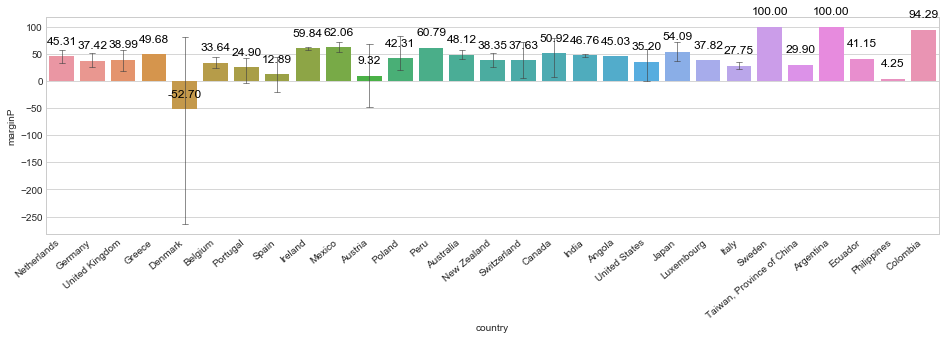

In [10]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="country", y="marginP", data=df_country, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

Available variables:
    
    Categorical:
    -name
    -managerName
    -client
    -client_id
    -country
    
    Continuous:
    -leads
    -revenue
    -margin
    -cpc
    -cpm
    -cpa
    -clicks
    -views
    
    %:
    -marginP
    -ctr
    -cr

______

# 2. Performance per Marketer

### 2.1 Margin % of marketer's campaigns 

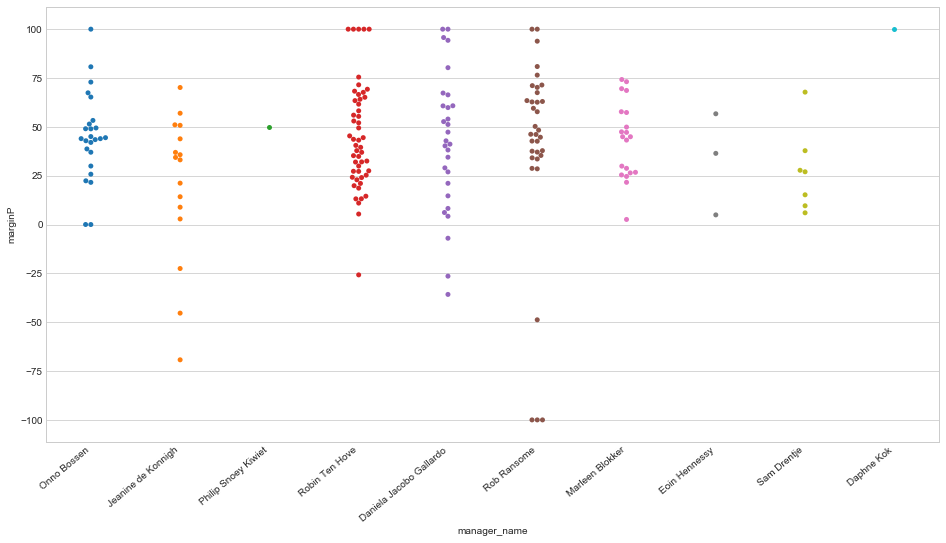

In [11]:
plt.pyplot.figure(figsize=(16,8))
ka=sns.swarmplot(x="manager_name", y="marginP", data=df_country.loc[df_country["marginP"]>=-100])
ka.set_xticklabels(ka.get_xticklabels(), rotation=40, ha="right")
ka

In [51]:
#total by marketer
df_country['total']=1
df_marketer=df_country.groupby(by=['manager_name']).sum()

### 2.2 Margin made per Marketer

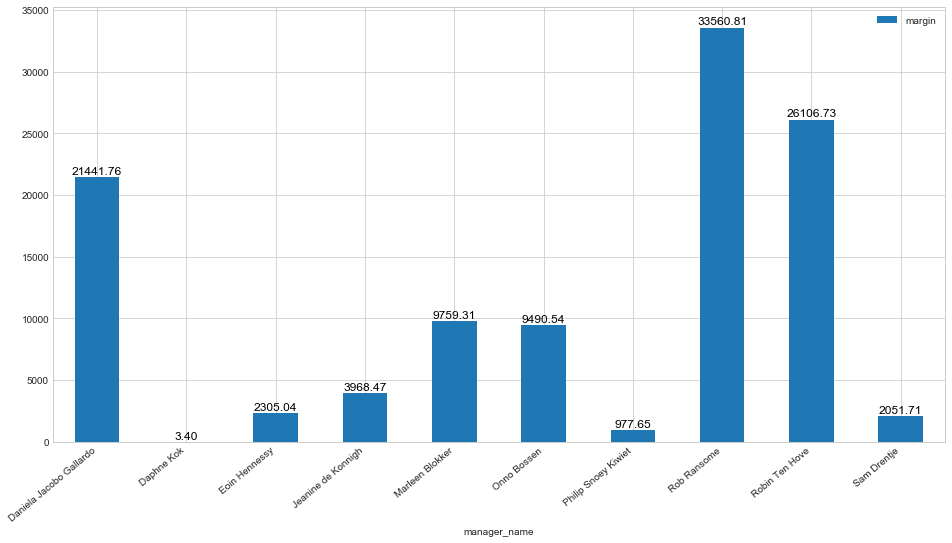

<Figure size 1152x576 with 0 Axes>

In [60]:
pa=df_marketer[["margin"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 2.3 Average campaign margin per marketer

In [58]:
#creating new variable
df_marketer["average"]=df_marketer["margin"]/df_marketer["total"]

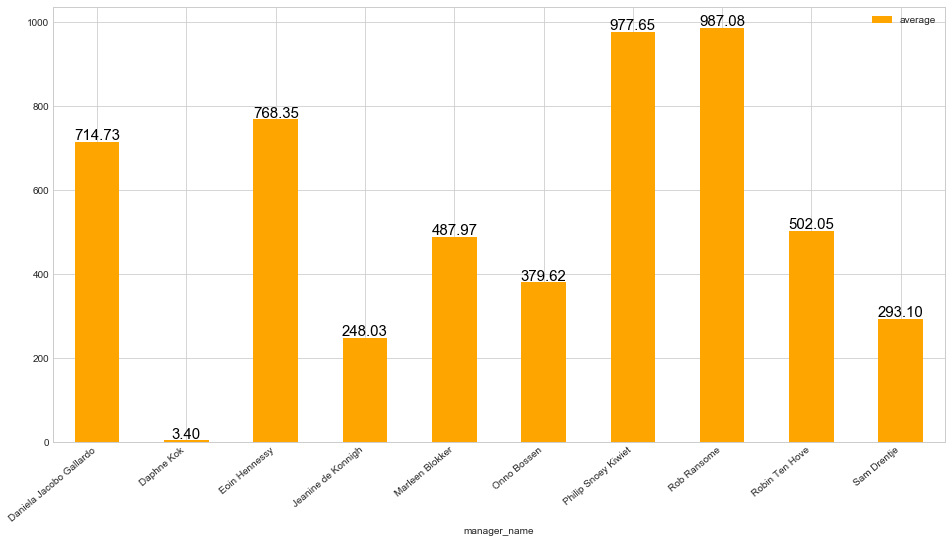

<Figure size 1152x576 with 0 Axes>

In [63]:
pa=df_marketer[["average"]].plot(kind="bar", figsize=(16,8), color="orange")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

________

# 3. Performance per Vertical

In [12]:
def yoo(x):
    if x["manager_name"]=="Onno Bossen" or x["manager_name"]=="Jeanine de Konnigh":
        return("other?")
    if x["manager_name"]=="Sam Drentje" or x["manager_name"]=="Marleen Blokker" or x["manager_name"]=="Daniela Jacobo Gallardo" or x["manager_name"]=="Daphne Kok":
        return("NGOs")
    if x["manager_name"]=="Philip Snoey Kiwiet" or x["manager_name"]=="Robin Ten Hove" or x["manager_name"]=="Rob Ransome" or x["manager_name"]=="Eoin Hennessy":
        return("hearing aids")
df_country["vertical"] = df_country.apply(yoo, axis=1)

### 3.1 Margin % per vertical

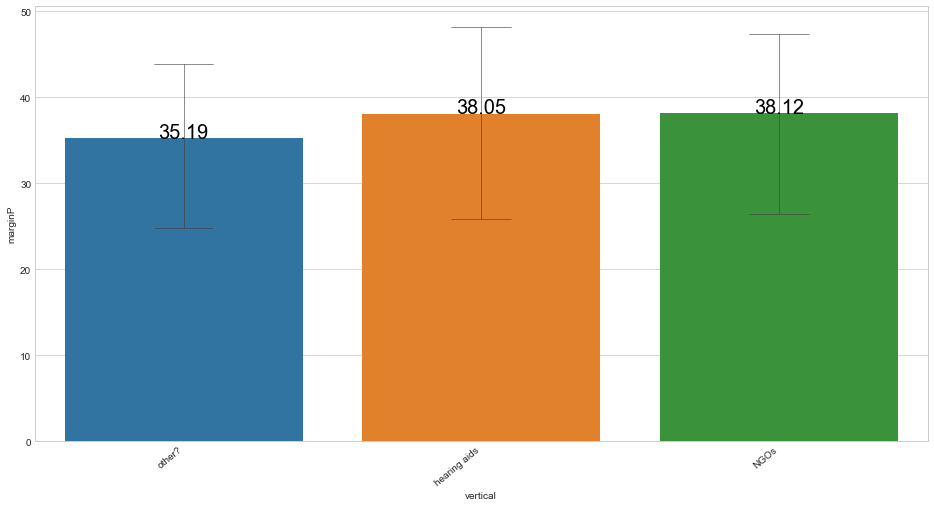

In [13]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="vertical", y="marginP", data=df_country, capsize=.2, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 6),
                 textcoords="offset points")

In [65]:
#total by vertical
df_vertical=df_country.groupby(by=['vertical']).sum()

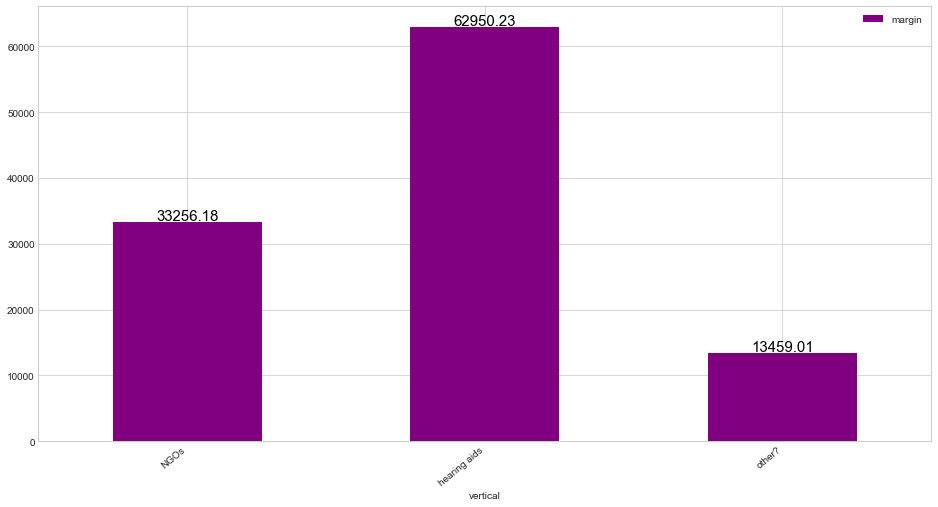

In [71]:
pa=df_vertical[["margin"]].plot(kind="bar", figsize=(16,8), color="purple")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

___________

# 4. Performance per Day of the Week

In [14]:
#importing multiple files using glob
#getting bert data
sheetnames=glob.glob("23__*.xlsx")
list_of_dfs = [pd.read_excel(sheet) for sheet in sheetnames]
for dataframe, sheet in zip(list_of_dfs, sheetnames):
    dataframe["day_num"] = sheet
df_daily = pd.concat(list_of_dfs, ignore_index=True) 

### Cleaning

In [15]:
#creating day of the week variable
df_daily["day_num"]=df_daily["day_num"].str.split("_").str[2]
def doo(x):
    if x["day_num"] == "1.xlsx":
        return("monday")
    if x["day_num"] == "2.xlsx":
        return("tuesday")
    if x["day_num"] == "3.xlsx":
        return("wednesday")
    if x["day_num"] == "4.xlsx":
        return("thursday")
    if x["day_num"] == "5.xlsx":
        return("friday")
    if x["day_num"] == "6.xlsx":
        return("saturday")
    else:
        return("sunday")
df_daily["day"] = df_daily.apply(doo, axis=1)

#dropping unused columns
df_daily.drop(columns=["id","status","ad_set_manager_id","client_id","ap_campaign_id","ad_set_campaign_group_id",
                      "notification_stop_spend","notification_stop_spend_threshold","margin_percentage",
                      "facebook_business_id","maxleads","countryIso","url"], inplace=True)

#1. FIX CTR
def foo(x):
    if x["ctr"] >= 1:
        return(x["ctr"]/10000)
    else:
        return(x["ctr"])
df_daily["ctr"] = df_daily.apply(foo, axis=1)
df_daily["ctr"] = df_daily["ctr"].round(2)

#2. FIX CPC
def roo(x):
    if x["cpc"] >= 1 and x["cpc"] < 1000000:
        return(x["cpc"]/100000)
    if x["cpc"] >= 1000000:
        return(x["cpc"]/1000000)
    else:
        return(x["cpc"])
df_daily["cpc"] = df_daily.apply(roo, axis=1)
df_daily["cpc"] = df_daily["cpc"].round(2)

#3. FIX CPM
def coo(x):
    if x["cpm"] >= 1:
        return(x["cpm"]/1000000)
    else:
        return(x["cpm"])
df_daily["cpm"] = df_daily.apply(coo, axis=1)
df_daily["cpm"] = df_daily["cpm"].round(2)

#4. FIX CR
df_daily["cr"] = df_daily["cr"]/10000
df_daily["cr"] = df_daily["cr"].round(2)

#5. FIX CPA
def too(x):
    if x["cpa"] >= 1:
        return(x["cpa"]/1000000)
    else:
        return(x["cpa"])
df_daily["cpa"] = df_daily.apply(too, axis=1)
df_daily["cpa"] = df_daily["cpa"].round(2)

#6. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_daily["marginP"] = df_daily.apply(woo, axis=1)
df_daily["marginP"] = df_daily["marginP"].round(2)

#7. COUNTRY NAMES
df_daily["country"]=df_daily["iso_code"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_daily["country"] = df_daily["country"].apply(get_country_code)
df_daily.drop(columns=["iso_code"], inplace=True)

df_daily.drop(columns=["day_num"], inplace=True)

order=["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]

### Visualising

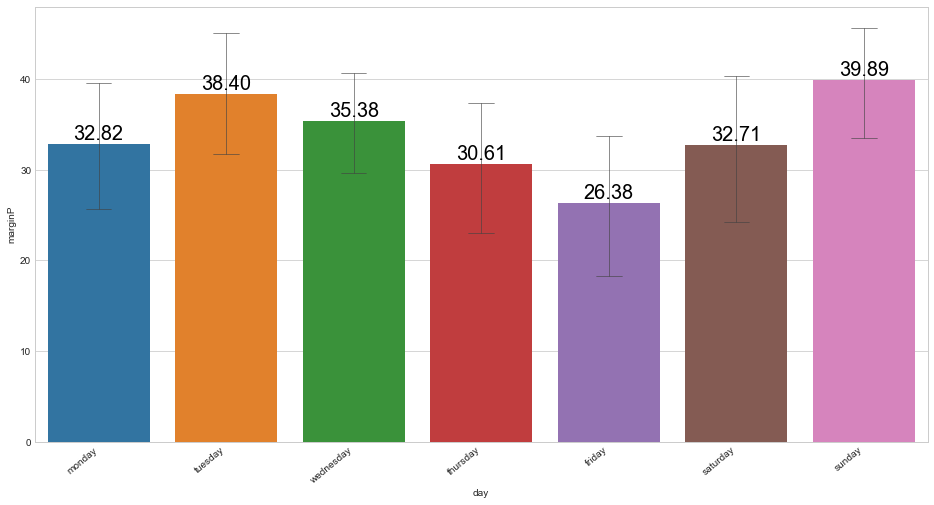

In [16]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="day", y="marginP", data=df_daily, capsize=.2, order=order, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 10),
                 textcoords="offset points")

##### cpa

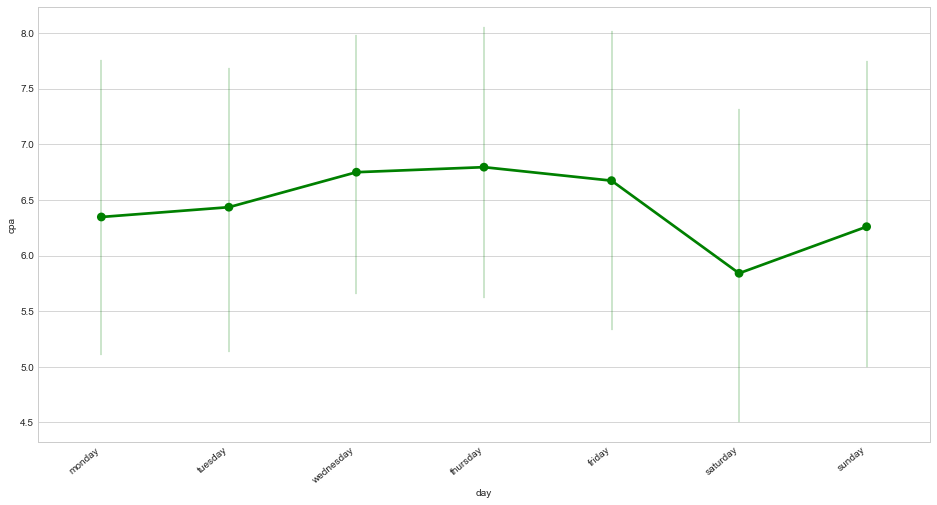

In [17]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpa", data=df_daily, order=order, color="g", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

##### cpc

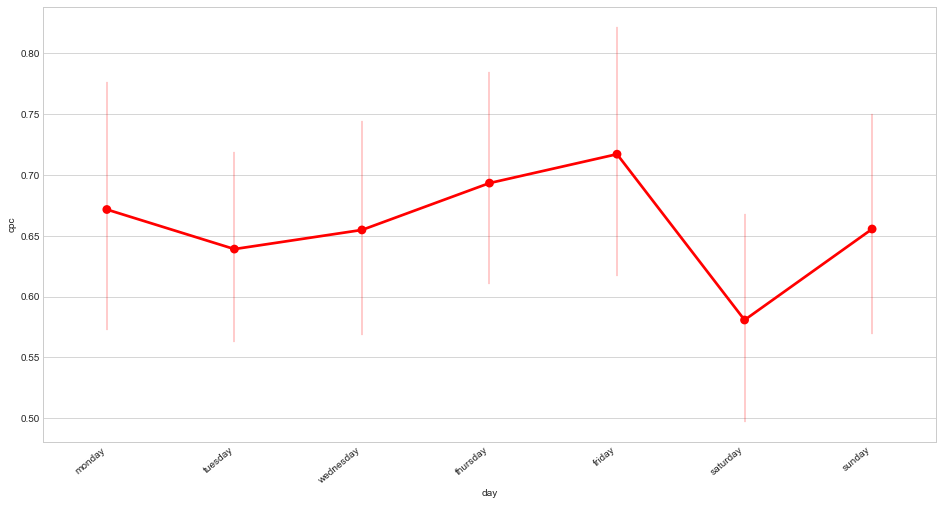

In [18]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpc", data=df_daily, order=order, color="r", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

##### cpm

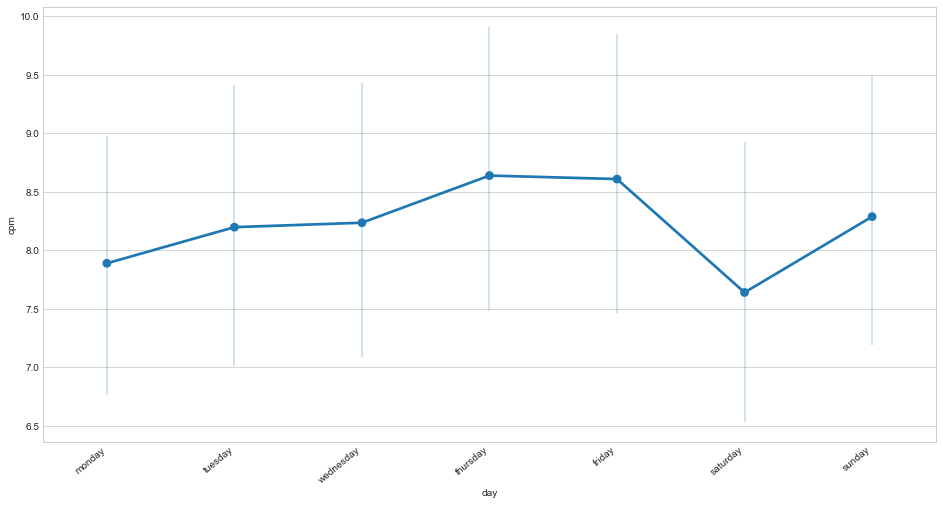

In [19]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpm", data=df_daily, order=order, dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
for p in ja.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### cr

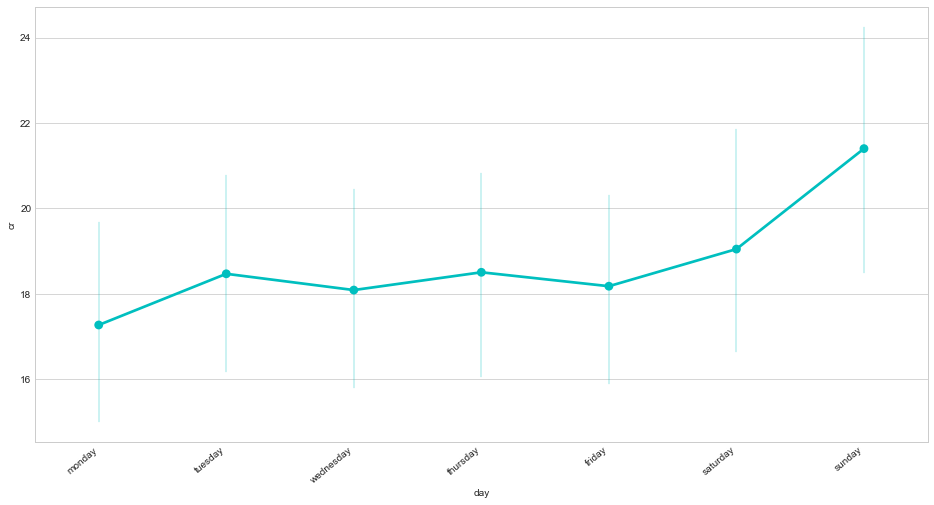

In [20]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cr", data=df_daily, order=order, color="c", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

##### ctr

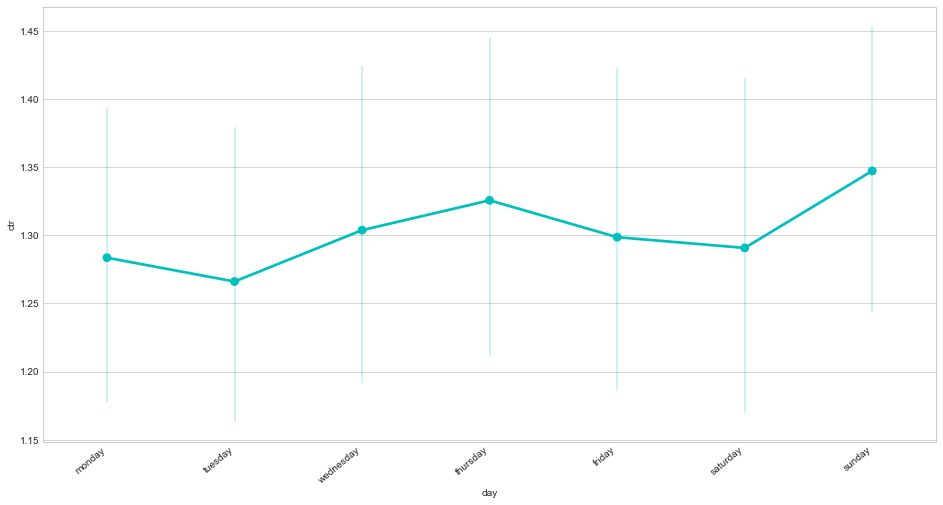

In [21]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="ctr", data=df_daily, order=order, color="c", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

_______

# 5. Top performing new ads (that were added during previous week)

##### Cleaning

In [22]:
df_raw=pd.read_excel("23_newads.xlsx")

#subsetting data
df_newads=df_raw.loc[df_raw["insert_time"]>=datetime(2018,6,4)]

#dropping columns
df_newads.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                       "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                       "short_url","ad_url_domain_id"], inplace=True)

#1. FIX CTR
# no fix needed
df_newads["ctr"] = df_newads["ctr"].round(2)

#2. FIX CPC
def roo(x):
    if x["cpc"] >= 1 and x["cpc"] < 1000000:
        return(x["cpc"]/100000)
    if x["cpc"] >= 1000000:
        return(x["cpc"]/1000000)
    else:
        return(x["cpc"])
df_newads["cpc"] = df_newads.apply(roo, axis=1)
df_newads["cpc"] = df_newads["cpc"].round(2)

#3. FIX CPM
def coo(x):
    if x["cpm"] >= 1:
        return(x["cpm"]/1000000)
    else:
        return(x["cpm"])
df_newads["cpm"] = df_newads.apply(coo, axis=1)
df_newads["cpm"] = df_newads["cpm"].round(2)

#4. No fix for CR needed.

#5. FIX CPA
def too(x):
    if x["cpa"] >= 1:
        return(x["cpa"]/1000000)
    else:
        return(x["cpa"])
df_newads["cpa"] = df_newads.apply(too, axis=1)
df_newads["cpa"] = df_newads["cpa"].round(2)

#6. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_newads["marginP"] = df_newads.apply(woo, axis=1)
df_newads["marginP"] = df_newads["marginP"].round(2)



The table below shows new ads that had a margin (percentage) above 50%. They are displayed in descending order from highest margin to lowest. Do these sybolise the most successful ads? We can play around with what matters. 



In [23]:
df_newads.loc[df_newads['marginP']>=50].nlargest(10,'margin')

,tag,campaign_name,name,budget,relevance_score,leads,revenue,purchase,margin,ctr,cpc,cpm,cr,cpa,insert_time,revenue_type,frequency,currency,marginP,views,clicks
2468,SB000000001151450,WWF CA,T 5 I Narwhal 2 M/V 23+ ALL LAL 10% donors,12.0,8,106,508.80,21.22,487.58,2.1,0.14,3.00,71.6,0.20,2018-06-06 11:13:16,10,101992000,CAD,95.83,7063,148
2469,SB000000001151453,WWF CA,T 5 I Narwhal 2 M/V 23+ ALL LAL 3% donors,8.0,9.8,88,422.40,16.80,405.60,2.0,0.16,3.18,84.6,0.19,2018-06-06 11:13:34,10,102420000,CAD,96.02,5283,104
2374,SB000000001150997,Blackberry Hearing,T4 istock C M/V 50+ M/D,80.0,2.3,28,595.00,215.15,379.85,0.8,0.39,3.09,5.1,7.68,2018-06-05 13:14:46,10,145692500,EUR,63.84,69538,554
2470,SB000000001151456,WWF CA,T 1 I black-footed ferrets 1 M/V 23+ ALL LAL 5...,10.0,9.8,79,379.20,15.67,363.53,2.7,0.13,3.35,63.2,0.20,2018-06-06 11:13:56,10,101002000,CAD,95.87,4674,125
2542,SB000000001152119,Schoonenberg - Luna 9 - QZ V5 - A,T6 V SB May3 B M/F 50+ ALL,75.0,5,28,369.60,111.59,258.01,1.3,0.53,6.68,13.3,3.99,2018-06-07 16:11:29,10,113807500,EUR,69.81,16709,210
2310,SB000000001150715,Victims Support NZ - Family Violence - Lead Ads,T2 I iStock 7 M/V 35+ ALL LAL 1% Victim suppor...,30.0,7.8,70,374.74,125.19,249.55,2.3,0.80,18.19,44.9,1.79,2018-06-05 10:01:40,10,102541667,AUD,66.59,6882,156
2217,SB000000001150295,Ethiopiaid,T5 I AC M/V 35+ ALL,65.0,9.8,85,408.00,168.83,239.17,3.4,0.79,26.63,39.7,1.99,2018-06-04 14:08:49,10,101800000,AUD,58.62,6340,214
2473,SB000000001151480,AudicaoActiva PT - ReSound - Lead Ads - New,LEAD AD T1 V DESIGN BV M/V 50+ ALL,40.0,2.4,25,416.25,181.93,234.32,1.8,0.23,4.14,3.1,7.28,2018-06-06 13:27:40,60,101258000,EUR,56.29,43946,805
2304,SB000000001150652,Connect Hearing - Hearing Studio - Lyric,T1 IHAC AB M/F 45+ D/M,40.0,5,13,286.00,52.68,233.32,2.8,1.01,28.26,25.0,4.05,2018-06-04 17:14:16,10,100930000,EUR,81.58,1864,52
2306,SB000000001150661,Connect Hearing - Hearing Studio - Lyric,T9 I Lyric selectie 1 M/F 45+ D/M,40.0,6,13,286.00,53.61,232.39,2.1,1.22,25.50,29.5,4.12,2018-06-04 17:15:15,10,101730000,EUR,81.26,2102,44



e.g. this shows the top 10 margin (percentage) ads that had margins of over €150, ordered from highest conversion rate to lowest conversion rate.


In [24]:
df_newads.loc[df_newads['margin']>=150].nlargest(10,'marginP').sort_values(by='cr', ascending=False)

,tag,campaign_name,name,budget,relevance_score,leads,revenue,purchase,margin,ctr,cpc,cpm,cr,cpa,insert_time,revenue_type,frequency,currency,marginP,views,clicks
2469,SB000000001151453,WWF CA,T 5 I Narwhal 2 M/V 23+ ALL LAL 3% donors,8.0,9.8,88,422.40,16.80,405.60,2.0,0.16,3.18,84.6,0.19,2018-06-06 11:13:34,10,102420000,CAD,96.02,5283,104
2468,SB000000001151450,WWF CA,T 5 I Narwhal 2 M/V 23+ ALL LAL 10% donors,12.0,8,106,508.80,21.22,487.58,2.1,0.14,3.00,71.6,0.20,2018-06-06 11:13:16,10,101992000,CAD,95.83,7063,148
2470,SB000000001151456,WWF CA,T 1 I black-footed ferrets 1 M/V 23+ ALL LAL 5...,10.0,9.8,79,379.20,15.67,363.53,2.7,0.13,3.35,63.2,0.20,2018-06-06 11:13:56,10,101002000,CAD,95.87,4674,125
2310,SB000000001150715,Victims Support NZ - Family Violence - Lead Ads,T2 I iStock 7 M/V 35+ ALL LAL 1% Victim suppor...,30.0,7.8,70,374.74,125.19,249.55,2.3,0.80,18.19,44.9,1.79,2018-06-05 10:01:40,10,102541667,AUD,66.59,6882,156
2217,SB000000001150295,Ethiopiaid,T5 I AC M/V 35+ ALL,65.0,9.8,85,408.00,168.83,239.17,3.4,0.79,26.63,39.7,1.99,2018-06-04 14:08:49,10,101800000,AUD,58.62,6340,214
2306,SB000000001150661,Connect Hearing - Hearing Studio - Lyric,T9 I Lyric selectie 1 M/F 45+ D/M,40.0,6,13,286.00,53.61,232.39,2.1,1.22,25.50,29.5,4.12,2018-06-04 17:15:15,10,101730000,EUR,81.26,2102,44
2304,SB000000001150652,Connect Hearing - Hearing Studio - Lyric,T1 IHAC AB M/F 45+ D/M,40.0,5,13,286.00,52.68,233.32,2.8,1.01,28.26,25.0,4.05,2018-06-04 17:14:16,10,100930000,EUR,81.58,1864,52
2542,SB000000001152119,Schoonenberg - Luna 9 - QZ V5 - A,T6 V SB May3 B M/F 50+ ALL,75.0,5,28,369.60,111.59,258.01,1.3,0.53,6.68,13.3,3.99,2018-06-07 16:11:29,10,113807500,EUR,69.81,16709,210
2374,SB000000001150997,Blackberry Hearing,T4 istock C M/V 50+ M/D,80.0,2.3,28,595.00,215.15,379.85,0.8,0.39,3.09,5.1,7.68,2018-06-05 13:14:46,10,145692500,EUR,63.84,69538,554
2473,SB000000001151480,AudicaoActiva PT - ReSound - Lead Ads - New,LEAD AD T1 V DESIGN BV M/V 50+ ALL,40.0,2.4,25,416.25,181.93,234.32,1.8,0.23,4.14,3.1,7.28,2018-06-06 13:27:40,60,101258000,EUR,56.29,43946,805


______________

# 6. Campaigns that are dropping in margin from 45% + to below 45%+

In [25]:
#importing new dataset
df_comp_raw=pd.read_excel("23_newads_comp.xlsx")


####FOR WEEK BEFORE DF####


#dropping columns
df_comp_raw.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                          "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                          "short_url","ad_url_domain_id"], inplace=True)

#1. FIX CTR
#df_comp_raw["ctr"] = df_comp_raw.apply(foo, axis=1)
df_comp_raw["ctr"] = df_comp_raw["ctr"].round(2)

#2. FIX CPC
df_comp_raw["cpc"] = df_comp_raw.apply(roo, axis=1)
df_comp_raw["cpc"] = df_comp_raw["cpc"].round(2)

#3. FIX CPM
df_comp_raw["cpm"] = df_comp_raw.apply(coo, axis=1)
df_comp_raw["cpm"] = df_comp_raw["cpm"].round(2)

#4. No fix for CR needed.

#5. FIX CPA
df_comp_raw["cpa"] = df_comp_raw.apply(too, axis=1)
df_comp_raw["cpa"] = df_comp_raw["cpa"].round(2)

#6. FIX MARGIN_P
df_comp_raw["marginP"] = df_comp_raw.apply(woo, axis=1)
df_comp_raw["marginP"] = df_comp_raw["marginP"].round(2)



####FOR FULL RAW WEEK#####


#dropping columns
df_raw.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                     "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                     "short_url","ad_url_domain_id"], inplace=True)

#1. FIX CTR
#df_raw["ctr"] = df_raw.apply(foo, axis=1)
df_raw["ctr"] = df_raw["ctr"].round(2)

#2. FIX CPC
df_raw["cpc"] = df_raw.apply(roo, axis=1)
df_raw["cpc"] = df_raw["cpc"].round(2)

#3. FIX CPM
df_raw["cpm"] = df_raw.apply(coo, axis=1)
df_raw["cpm"] = df_raw["cpm"].round(2)

#4. No fix for CR needed.

#5. FIX CPA
df_raw["cpa"] = df_raw.apply(too, axis=1)
df_raw["cpa"] = df_raw["cpa"].round(2)

#6. FIX MARGIN_P
df_raw["marginP"] = df_raw.apply(woo, axis=1)
df_raw["marginP"] = df_raw["marginP"].round(2)


#####SLIMMING COMB DATA DOWN TO ONLY INCLUDE MARGINS ABOVE 45%###########
df_comp=df_comp_raw.loc[df_comp_raw["marginP"]>=45]

####COMBING DATA SETS########
df_campaign2=df_comp.merge(df_raw, how ="inner", on = ["tag"])

The list below contains every ad that went from being 45% margin or higher, but dropped below 45% margin the following week. 
 

In [26]:
df_campaign=df_campaign2.loc[df_campaign2["marginP_y"]<45]
df_campaign

,tag,campaign_name_x,name_x,budget_x,relevance_score_x,leads_x,revenue_x,purchase_x,margin_x,ctr_x,cpc_x,cpm_x,cr_x,cpa_x,insert_time_x,revenue_type_x,frequency_x,currency_x,marginP_x,views_x,clicks_x,campaign_name_y,name_y,budget_y,relevance_score_y,leads_y,revenue_y,purchase_y,margin_y,ctr_y,cpc_y,cpm_y,cr_y,cpa_y,insert_time_y,revenue_type_y,frequency_y,currency_y,marginP_y,views_y,clicks_y
1,SB000000001024475,Care Vision DE,T2 IN m/v 25-40 M 1% LAL CV + PV Aangepast NBM...,25.0,7,8,98.00,34.59,63.41,1.6,0.79,12.51,18.2,4.32,2016-11-01 14:51:43,10,101120000,EUR,64.70,2765,44,Care Vision DE,T2 IN m/v 25-40 M 1% LAL CV + PV Aangepast NBM...,25.0,7.8,18,220.50,125.97,94.53,1.7,0.76,12.69,10.8,7.00,2016-11-01 14:51:43,10,100942857,EUR,42.87,9930,166
2,SB000000001031138,Bonavox,T2 IF MV50+ M/D/A/RC,60.0,3.2,14,365.40,143.57,221.83,0.6,0.85,5.34,8.3,10.26,2016-12-05 10:28:51,10,132828000,EUR,60.71,26864,168,Bonavox,T2 IF MV50+ M/D/A/RC,60.0,3.2,6,156.60,164.24,-7.64,0.4,1.01,4.32,3.7,27.37,2016-12-05 10:28:51,10,153387500,EUR,-4.88,37999,162
7,SB000000001053719,Twin Properties - Tr√©sors d‚ÄôOpale BEFR - le...,T4 I Canva 15 30+ DM,20.0,7.6,5,120.00,65.76,54.24,2.0,0.64,13.06,4.9,13.15,2017-04-10 15:14:18,60,104256667,EUR,45.20,5037,103,Twin Properties - Tr√©sors d‚ÄôOpale BEFR - le...,T4 I Canva 15 30+ DM,20.0,6,1,24.00,23.53,0.47,1.6,0.67,10.48,2.9,23.53,2017-04-10 15:14:18,60,102950000,EUR,1.96,2246,35
9,SB000000001074092,Victor Chang Institute Australia petition,T2.8 I Istock Juli3 E M/V 25+ ALL,7.5,9.1,15,43.80,22.01,21.79,1.1,0.49,5.22,33.3,1.47,2017-08-09 14:38:02,10,102610000,EUR,49.75,4219,45,Victor Chang Institute Australia petition,T2.8 I Istock Juli3 E M/V 25+ ALL,7.5,10.9,31,90.52,53.36,37.16,1.0,0.54,5.56,31.6,1.72,2017-08-09 14:38:02,10,102002857,EUR,41.05,9595,98
13,SB000000001081712,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Mons M/V 25+ ALL STR1,5.0,6.5,20,48.00,15.19,32.81,1.1,0.34,3.70,44.4,0.76,2017-09-19 09:59:10,10,113353333,EUR,68.35,4103,45,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Mons M/V 25+ ALL STR1,5.0,7.6,20,48.00,31.91,16.09,0.9,0.45,4.11,28.2,1.60,2017-09-19 09:59:10,10,112392857,EUR,33.52,7759,71
17,SB000000001085423,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Ath M/V 25+ ALL STR1,2.0,7,6,14.40,6.02,8.38,1.1,0.43,4.80,42.9,1.00,2017-10-05 09:17:23,10,107893333,EUR,58.19,1253,14,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Ath M/V 25+ ALL STR1,2.0,0,0,0.00,0.72,-0.72,1.0,0.36,3.50,0.0,0.00,2017-10-05 09:17:23,10,105640000,EUR,-100.00,206,2
20,SB000000001085441,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Braine-le-Comte M/V 25+ ALL STR1,2.0,7,9,21.60,5.98,15.62,1.7,0.27,4.66,40.9,0.66,2017-10-05 09:19:05,10,119573333,EUR,72.31,1282,22,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Braine-le-Comte M/V 25+ ALL STR1,2.0,7,9,21.60,12.91,8.69,1.2,0.39,4.62,27.3,1.43,2017-10-05 09:19:05,10,112978571,EUR,40.23,2797,33
22,SB000000001085963,HelloFresh NL - Spaanse Keukenquiz,T 7 I istock Aug1 G [Maastricht] M/V 23+ ALL C...,3.0,0,9,22.95,11.19,11.76,2.4,0.23,5.37,18.4,1.24,2017-10-06 10:44:37,10,102690000,EUR,51.24,2085,49,HelloFresh NL - Spaanse Keukenquiz,T 7 I istock Aug1 G [Maastricht] M/V 23+ ALL C...,3.0,0,0,0.00,1.33,-1.33,1.9,0.33,6.19,0.0,0.00,2017-10-06 10:44:37,10,101420000,EUR,-100.00,215,4
24,SB000000001086904,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Ch√¢telet M/V 25+ ALL STR1,2.0,7,6,14.40,6.06,8.34,1.1,0.40,4.26,40.0,1.01,2017-10-11 14:11:47,10,115630000,EUR,57.92,1423,15,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Ch√¢telet M/V 25+ ALL STR1,2.0,7,6,14.40,12.98,1.42,1.0,0.50,4.82,23.1,2.16,2017-10-11 14:11:47,10,110820000,EUR,9.86,2694,26
25,SB000000001086955,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Philippeville M/V 25+ ALL STR1,2.0,0,10,24.00,5.94,18.06,1.9,0.31,5.90,52.6,0.59,2017-10-11 14:27:29,10,123580000,EUR,75.25,1007,19,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Philippeville M/V 25+ ALL STR1,2.0,0,6,14.40,12.89,1.51,0.6,0.86,5.04,40.0,2.15,2017-10-

.. there are 411

In [27]:
#making difference variable
df_campaign["diff"]=df_campaign["marginP_x"]-(df_campaign["marginP_y"])

These are the 20 ads that had the biggest differences (in margin percentage) between the two weeks. 

In [28]:
df_campaign.nlargest(20,'diff')

,tag,campaign_name_x,name_x,budget_x,relevance_score_x,leads_x,revenue_x,purchase_x,margin_x,ctr_x,cpc_x,cpm_x,cr_x,cpa_x,insert_time_x,revenue_type_x,frequency_x,currency_x,marginP_x,views_x,clicks_x,campaign_name_y,name_y,budget_y,relevance_score_y,leads_y,revenue_y,purchase_y,margin_y,ctr_y,cpc_y,cpm_y,cr_y,cpa_y,insert_time_y,revenue_type_y,frequency_y,currency_y,marginP_y,views_y,clicks_y,diff
254,SB000000001132589,GEERS DE - IIC QZ V3 - New - Cities,T 5 V SB Mar3 A M/F 50+ ALL Provincie Saarland,20.0,3,14,252.00,138.40,113.60,1.1,0.90,9.51,9.1,9.89,2018-04-16 15:27:50,10,119824286,EUR,45.08,14554,154,GEERS DE - IIC QZ V3 - New - Cities,T 5 V SB Mar3 A M/F 50+ ALL Provincie Saarland,20.0,3,3,54.0,139.59,-85.59,1.0,1.05,10.95,2.3,46.53,2018-04-16 15:27:50,10,118372857,EUR,-158.5,12748,133,203.58
839,SB000000001149044,HearingLife City Ads 2.0,T4 May I stock Apr1 C M/V 50+ ALL - Uxbridge,3.0,0,3,59.40,3.89,55.51,3.7,0.78,28.60,60.0,1.30,2018-05-30 13:58:46,10,100000000,CAD,93.45,136,5,HearingLife City Ads 2.0,T4 May I stock Apr1 C M/V 50+ ALL - Uxbridge,3.0,0,0,0.0,10.86,-10.86,1.4,1.81,25.80,0.0,0.00,2018-05-30 13:58:46,10,102092857,CAD,-100.0,421,6,193.45
866,SB000000001149953,Bloom Hearing UK - beyond RSP - City ads,Sunderland - City5 V colour BEYOND VC M/V 50+ ALL,3.0,0,1,26.10,2.00,24.10,4.5,0.22,9.95,11.1,2.00,2018-06-01 13:34:51,10,103610000,EUR,92.34,201,9,Bloom Hearing UK - beyond RSP - City ads,Sunderland - City5 V colour BEYOND VC M/V 50+ ALL,3.0,0,0,0.0,13.65,-13.65,2.8,0.55,15.35,0.0,0.00,2018-06-01 13:34:51,10,102844000,EUR,-100.0,889,25,192.34
824,SB000000001148915,HearingLife City Ads 2.0,T4 May I stock Apr1 C M/V 50+ ALL - Penticton,3.0,0,2,39.60,4.48,35.12,3.6,0.90,32.00,40.0,2.24,2018-05-30 13:39:58,10,101470000,CAD,88.69,140,5,HearingLife City Ads 2.0,T4 May I stock Apr1 C M/V 50+ ALL - Penticton,3.0,0,0,0.0,11.12,-11.12,1.8,1.59,28.37,0.0,0.00,2018-05-30 13:39:58,10,101330000,CAD,-100.0,392,7,188.69
821,SB000000001148906,HearingLife City Ads 2.0,T4 May I stock Apr1 C M/V 50+ ALL - Ottawa,3.0,0,2,39.60,4.52,35.08,3.9,0.65,25.25,28.6,2.26,2018-05-30 13:38:33,10,101136667,CAD,88.59,179,7,HearingLife City Ads 2.0,T4 May I stock Apr1 C M/V 50+ ALL - Ottawa,3.0,0,0,0.0,11.96,-11.96,1.0,2.39,24.46,0.0,0.00,2018-05-30 13:38:33,10,100250000,CAD,-100.0,489,5,188.59
675,SB000000001147679,Schoonenberg - Luna 9 - QZ - Cities,T6 V SB May1 A M/F 50+ - Papendrecht - City3,3.0,0,9,118.80,16.55,102.25,2.6,0.46,12.08,25.0,1.84,2018-05-29 11:38:23,10,104020000,EUR,86.07,1370,36,Schoonenberg - Luna 9 - QZ - Cities,T6 V SB May1 A M/F 50+ - Papendrecht - City3,3.0,0,0,0.0,12.12,-12.12,1.4,0.81,11.69,0.0,0.00,2018-05-29 11:38:23,10,102930000,EUR,-100.0,1037,15,186.07
762,SB000000001148510,AudicaoActiva PT - ReSound - lead ads,T1 I DESIGN A AV 50+ M/D,50.0,4.5,6,99.90,14.45,85.45,0.8,0.35,2.97,14.6,2.41,2018-05-30 11:55:50,60,103076000,EUR,85.54,4873,41,AudicaoActiva PT - ReSound - lead ads,T1 I DESIGN A AV 50+ M/D,50.0,0,0,0.0,1.42,-1.42,0.3,1.42,4.64,0.0,0.00,2018-05-30 11:55:50,60,100260000,EUR,-100.0,306,1,185.54
233,SB000000001130696,HearingLife Canada - city ads,I SB feb1 A M/V 50+ ALL -¬†Peterborough,3.0,0,5,99.00,16.21,82.79,1.5,1.16,17.72,35.7,3.24,2018-04-06 11:27:04,10,101585714,CAD,83.63,915,14,HearingLife Canada - city ads,I SB feb1 A M/V 50+ ALL -¬†Peterborough,3.0,0,0,0.0,4.57,-4.57,0.8,2.28,18.96,0.0,0.00,2018-04-06 11:27:04,10,100927500,CAD,-100.0,241,2,183.63
367,SB000000001139411,AudioNova DK - Moxi Now QZ - Cities,T 8 V SB Mar3 GP M/F 50+ ALL City-1-Skagen,3.0,0,5,90.00,14.94,75.06,1.8,0.83,14.88,27.8,2.99,2018-05-09 14:28:03,10,107377143,EUR,83.40,1004,18,AudioNova DK - Moxi Now QZ - Cities,T 8 V SB Mar3 GP M/F 50+ ALL City-1-Skagen,3.0,0,0,0.0,9.70,-9.70,1.6,0.88,14.39,0.0,0.00,2018-05-09 14:28:03,10,104768000,EUR,-100.0,674,11,183.40
175,SB000000001125221,GEERS DE - IIC QZ V3 - New - Cities,T 5 V SB Mar2 B M/F 50+ ALL City-01 -Krefeld,2.0,5,4,72.00,13.79,58.21,1.1,0.48,5.00,13.8,3.45,2018-03-26 14:48:52,10

______

### Other testing

In [29]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>

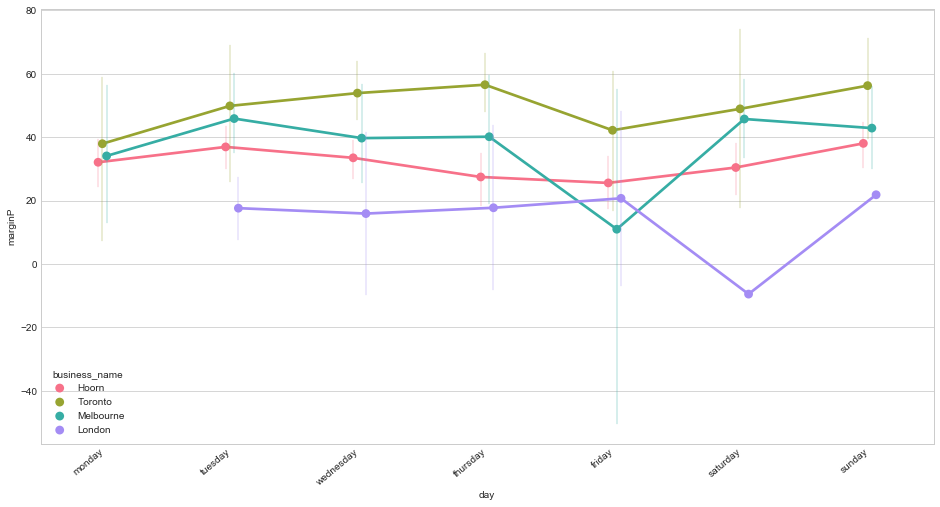

In [33]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="marginP", hue="business_name", data=df_daily, order=order, palette="husl", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

In [32]:
help(sns.pointplot)

Help on function pointplot in module seaborn.categorical:

pointplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, estimator=<function mean at 0x111cf2400>, ci=95, n_boot=1000, units=None, markers='o', linestyles='-', dodge=False, join=True, scale=1, orient=None, color=None, palette=None, errwidth=None, capsize=None, ax=None, **kwargs)
    Show point estimates and confidence intervals using scatter plot glyphs.
    
    A point plot represents an estimate of central tendency for a numeric
    variable by the position of scatter plot points and provides some
    indication of the uncertainty around that estimate using error bars.
    
    Point plots can be more useful than bar plots for focusing comparisons
    between different levels of one or more categorical variables. They are
    particularly adept at showing interactions: how the relationship between
    levels of one categorical variable changes across levels of a second
    categorical variable. The lines th